## Installation

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [5]:
#hide
from fastbook import *
from fastai import *
from fastai.vision import *
import keras.preprocessing.image as kpi

In [6]:
!unzip gdrive/My\Drive/ML/archive.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: dataset/dataset_updated/training_set/sculpture/i - 968 20.26.47.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 969.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 97.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 970.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 971.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 972.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 973.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 974.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 976.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 977.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 978.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 979.jpeg  
  inflating: d

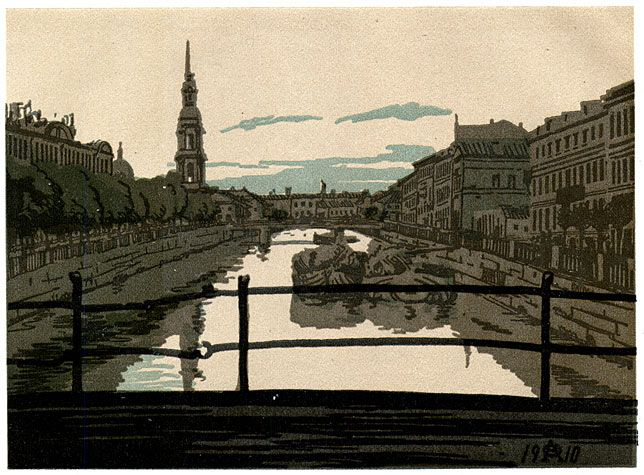

In [7]:
img = kpi.load_img('/content/dataset/dataset_updated/training_set/drawings/01dee7c857692cce250fcc7fba309f3f.jpg') 
img


# Préparation

Ici, avec get_image_files, on recupere l'ensemble des images qui nous servira ensuite de dataset de training.

In [9]:

fnames = get_image_files('/content/dataset/dataset_updated/training_set')
fns= get_image_files('/content/dataset/dataset_updated/validation_set')
fnames,fns

((#7819) [Path('/content/dataset/dataset_updated/training_set/sculpture/i - 954.jpeg'),Path('/content/dataset/dataset_updated/training_set/sculpture/i - 225.jpeg'),Path('/content/dataset/dataset_updated/training_set/sculpture/i - 174.jpeg'),Path('/content/dataset/dataset_updated/training_set/sculpture/281.jpg'),Path('/content/dataset/dataset_updated/training_set/sculpture/i - 641 20.26.47.jpeg'),Path('/content/dataset/dataset_updated/training_set/sculpture/228.jpg'),Path('/content/dataset/dataset_updated/training_set/sculpture/186.jpg'),Path('/content/dataset/dataset_updated/training_set/sculpture/i - 970.jpeg'),Path('/content/dataset/dataset_updated/training_set/sculpture/i - 753.jpeg'),Path('/content/dataset/dataset_updated/training_set/sculpture/i - 1010.jpeg')...],
 (#866) [Path('/content/dataset/dataset_updated/validation_set/sculpture/i - 1124.jpeg'),Path('/content/dataset/dataset_updated/validation_set/sculpture/i - 1361.jpeg'),Path('/content/dataset/dataset_updated/validation_s

On verifie s'il y a des images corrompues ou qui pouraient poser problèmes, avec la ligne "verify_images"

In [10]:
failed = verify_images(fnames)
failedv = verify_images(fns)
failed,failedv

((#98) [Path('/content/dataset/dataset_updated/training_set/sculpture/168.jpg'),Path('/content/dataset/dataset_updated/training_set/sculpture/190 18.59.45.jpg'),Path('/content/dataset/dataset_updated/training_set/sculpture/210.jpg'),Path('/content/dataset/dataset_updated/training_set/sculpture/107.jpg'),Path('/content/dataset/dataset_updated/training_set/sculpture/374.jpg'),Path('/content/dataset/dataset_updated/training_set/sculpture/200.jpg'),Path('/content/dataset/dataset_updated/training_set/sculpture/261.jpg'),Path('/content/dataset/dataset_updated/training_set/painting/0550.jpg'),Path('/content/dataset/dataset_updated/training_set/painting/1125.jpg'),Path('/content/dataset/dataset_updated/training_set/painting/0775.jpg')...],
 (#10) [Path('/content/dataset/dataset_updated/validation_set/sculpture/170.jpg'),Path('/content/dataset/dataset_updated/validation_set/sculpture/106.jpg'),Path('/content/dataset/dataset_updated/validation_set/painting/1250.jpg'),Path('/content/dataset/datas

On remarque qu'il y a 98 erreurs. Il faut les enlever. On utilise donc la ligne suivante :


In [11]:
failed.map(Path.unlink);

Une fois clean de toutes données problématiques, on peut stocker le chemin dans une variable


In [36]:
path='/content/dataset/dataset_updated/training_set'

In [37]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

On crée un DataBlock qui structura le model

In [38]:
art = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    #ici, on veut que notre datablock récupere les images de nos fichiers
    get_items=get_image_files, 
    #On coupe nos données en deux : 20 pourcents d'entre elles seront utilisées pour valider l'entrainement des 80% restants
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    #Chaque image est labélisé par le fichier d'où elle provient
    get_y=parent_label,
    #On resize les images, cad qu'on les met à la même taille afin de pouvoir les utiliser sans problèmes
    item_tfms=Resize(128))

On transforme notre datablock en un set 

In [39]:
dls = art.dataloaders(path)
dls

On affiche ici 4 extraits du set aléatoirement, pour vérifier que tout fonctionne.

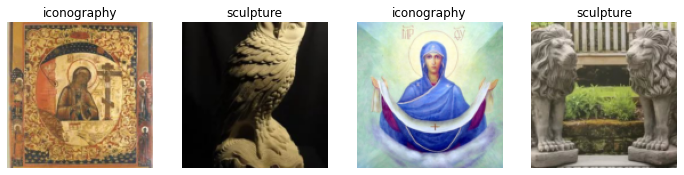

In [40]:
dls.valid.show_batch(max_n=4, nrows=1)

Ici, on va faire de l'augmentation de Data, CaD on va créer des variations aléatoires des données que nous allons utilisés, afin de créer du bruit, et permettre une meilleure détéction/un meilleur apprentissage du model.

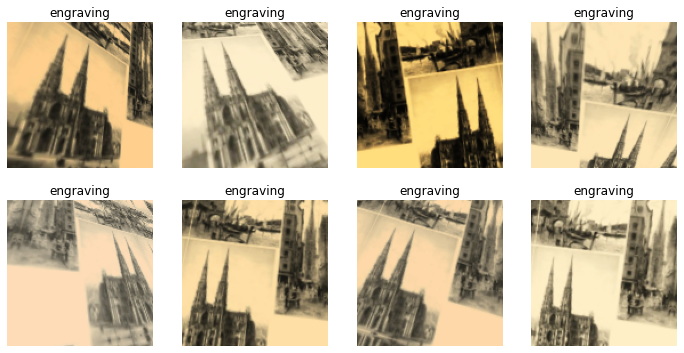

In [41]:
art = art.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = art.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

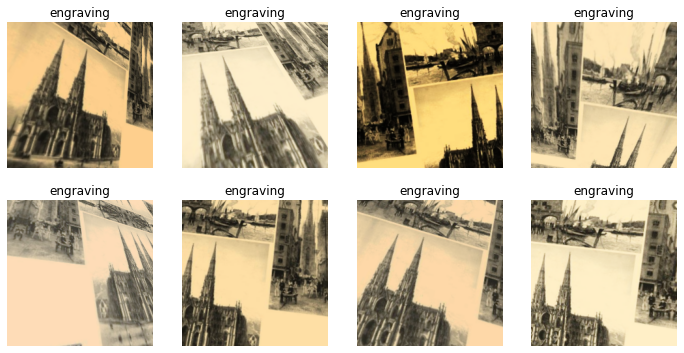

In [42]:
art = art.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2))
dls = art.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Apprentissage

Maintenant, on peut entrainer notre model. J'ai choisi le resnet50 car, ayant essayer avec le 18, 34, 50 et 101, on retrouve une difference assez importante entre le 18,34 et 50, mais beaucoup moins entre le 50 et le 101. Par conséquent, par soucis d'optimisations, le resnet 50 me semble suffisant.
Après avoir fait plusieurs tests, j'ai choisi de faire 10 "passes" au model; comme tu peux le voir, les pourcentages d'échecs sont assez bas.

In [44]:
learn = cnn_learner(dls, resnet50, metrics=[error_rate,accuracy])
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.605071,0.337377,0.106865,0.893135,01:14


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.295846,0.198521,0.074482,0.925518,01:34
1,0.273218,0.192763,0.069948,0.930052,01:35
2,0.229201,0.231561,0.073187,0.926813,01:34
3,0.192515,0.204009,0.069301,0.930699,01:35
4,0.168941,0.186758,0.061528,0.938471,01:35
5,0.119845,0.205969,0.066710,0.933290,01:35
6,0.105505,0.174562,0.054404,0.945596,01:34
7,0.084435,0.178363,0.053109,0.946891,01:35
8,0.058667,0.163452,0.049223,0.950777,01:35
9,0.048272,0.162995,0.047927,0.952073,01:35


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

Ici, on va créer une matrice de confusion, nous permettant de nous donner une idée de la repartition des erreurs du model.

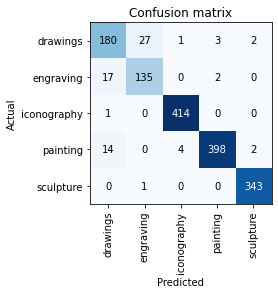

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

On se retrouve avec une matric correcte, et ainsi un model bien fonctionnel avec 5% d'echecs.

In [62]:
from fastai.vision.widgets import *
#cleaner = ImageClassifierCleaner(learn)

In [55]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Maitenant, on va exporter le model.

In [64]:
Learner.export(learn, fname='/content/gdrive/MyDrive/ML/art-classification.pkl')
path = Path()
path.ls

<bound method Path.ls of Path('.')>

## Utiliser le model

Si vous n'avez pas fait tourner le model précédent, il est trouvable ici = https://drive.google.com/file/d/1-9Ut2fTWHNgX0ABdqCnIn0iofE23Gthv/view
Uploadez le sur votre drive google directement à la racine, puis executez la commande suivante

In [71]:
learn_inf = load_learner('/content/gdrive/MyDrive/ML/art-classification.pkl')

Ici, on crée un petit GUI pour pouvoir utiliser le model

In [72]:
from ipywidgets import *

lbl_pred = widgets.Label()
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
btn_run = widgets.Button(description='Classify')
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)
VBox([widgets.Label('Select your art to identitfy !'), 
      btn_upload, btn_run, out_pl, lbl_pred])